# skill recommender
Assuming a person has some subset of skills from the ESCO dataset. Recommend other skills that this person might also have.

## preliminaries
We import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import random
from py2neo import Graph
from sklearn.manifold import TSNE
import seaborn as sns

We connect to our locally running neo4j database.

In [9]:
with open('../credentials.txt','r') as f:
    ls = f.read().split(', ')

DN_HOST = 'localhost'
DB_PORT = 7687
DB_USERNAME = ls[0]
DB_PW = ls[1]
DB_NAME = 'neo4j'

graph = Graph(
    host=DN_HOST,
    port=DB_PORT,
    user=DB_USERNAME,
    password=DB_PW,
    name=DB_NAME
)

## node2vec
We make an embedding of the skill node via the node2vec algorithm. An amazing explanation of the algorithm can be found in the Graph data science course of Stanford university. ([course](http://web.stanford.edu/class/cs224w/), [youtube lectures](https://www.youtube.com/watch?v=Xv0wRy66Big&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&index=1), [node2vec lecture](https://www.youtube.com/watch?v=Xv0wRy66Big&list=PLoROMvodv4rPLKxIpqhjhPgdQy7imNkDn&index=8))

We use the node2vec algorithm on the graph consisting of the skill nodes and the CO_SKILL relations. We use a weighted node2vec based on the weights of the CO_SKILL relations.

We don't tweak any hyperparemeters. A list of all the possible hyperparameter choices and defaults is listed [here](https://neo4j.com/docs/graph-data-science/current/algorithms/node2vec/).

The embedding that is made by the algorithm gets written as a property 'embedding' to the skill nodes.

### CO_SKILL
(DEPRACATED: works the same in principle, but in practice it is now implemented differently)

from the ESCO dataset, we have occupation linked with their 'essential skills' and 'optional skills'. If 2 skills occur in the same occupation, a CO_SKILL relation between them is made.

The weight of the CO_SKILL relation is dependant on the type of link between the skills and the occupation. I have chosen the following heuristic weighting rule (It is completely possible to find another, better rule, after some experimentation):
- if 2 skills are optional skills from an occupation, the CO_SKILL weighting is 1
- if 1 of the skills is optional and the other essential, the CO_SKILL weighting is 2
- if both skills are essential, the CO_SKILL weighting is 4

2 skills can share more than a single occuption. In this case the CO_SKILL weightings are simply added together.

In [4]:
graph.run("""
    CALL gds.beta.node2vec.write({
    nodeQuery:'MATCH (n:skill) RETURN id(n) AS id',
    relationshipQuery:'MATCH (n)<-[a:REQUIRES_SKILL]-()-[b:REQUIRES_SKILL]->(m)
        RETURN id(n) AS source, id(m) AS target, sum(a.weight*b.weight) AS weight',
    writeProperty:'embedding',
    relationshipWeightProperty:'weight'})
""")

nodeCount,nodePropertiesWritten,createMillis,computeMillis,writeMillis,configuration
12600,12600,5886,32021,427,"{negativeSamplingExponent: 0.75, initialLearningRate: 0.025, writeConcurrency: 4, negativeSamplingRate: 5, walksPerNode: 10, positiveSamplingFactor: 0.001, relationshipWeightProperty: 'weight', iterations: 1, concurrency: 4, returnFactor: 1.0, walkLength: 80, windowSize: 10, writeProperty: 'embedding', inOutFactor: 1.0, embeddingDimension: 128, nodeLabels: ['*'], sudo: false, minLearningRate: 0.0001, relationshipTypes: ['*'], walkBufferSize: 1000, username: null}"


The embedding is made in 128 dimensions. We use the T-SNE algorithm to plot the embedding in 2 dimensions.

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

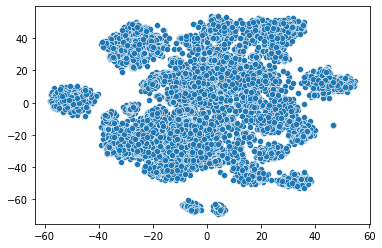

In [11]:
embed_df = graph.run("""
    MATCH (n:skill) RETURN n.embedding AS node_embedding, n.name AS name
""").to_data_frame()
node_embed_2d = TSNE().fit_transform(np.array([x for x in embed_df['node_embedding']]))
sns.scatterplot(x=[x[0] for x in node_embed_2d],y=[x[1] for x in node_embed_2d])

Looks good. We see that some skills form 'islands' they seem to mostly interrelated and detached from the other skills.
This makes sense. As an example, A person with a lot of woodworking related skills won't be likely to be skilled in financial analysis or related activities.

We now do some preprocessing on the embedding to get it prepared for the similarity algorithm that will follow.

In [12]:
np_embed = []
for embed in embed_df['node_embedding']:
    np_embed.append(np.array(embed))
embed_df['np_node_embedding'] = np_embed
embed_df.head()

,node_embedding,name,np_node_embedding
0,"[0.40986692905426025, -0.07915084809064865, 0....",3D texturing,"[0.40986692905426025, -0.07915084809064865, 0...."
1,"[0.010787277482450008, 0.24133802950382233, -0...",collaborate on international energy projects,"[0.010787277482450008, 0.24133802950382233, -0..."
2,"[0.27119505405426025, 0.10448812693357468, 0.2...",conduct energy audit,"[0.27119505405426025, 0.10448812693357468, 0.2..."
3,"[0.8750394582748413, 0.2750485837459564, 0.241...",forecast energy prices,"[0.8750394582748413, 0.2750485837459564, 0.241..."
4,"[0.4691600203514099, 0.22101634740829468, 0.32...",develop energy policy,"[0.4691600203514099, 0.22101634740829468, 0.32..."


In the next block the pairwise euclidean (L2) distances are calculated from the skill embeddings. This will be our measure of 'likeness' of 2 skills.

NOTE: This block might take a while to run as there are about 15k skills, and so about 225 million = (15k X 15k) distances.

TODO: change the algorithm to only calculate the bottom triangle of the matrix, as it is a symmetric matrix anyway. This halves the time to calculate.

In [13]:
##############################
#                            #
#     use this to calculate  #
#     the distance matrix    #
#                            #
##############################
distance_mat = np.zeros((len(embed_df),len(embed_df)))
for i,embed in enumerate(embed_df['np_node_embedding']):
    for j,embed2 in enumerate(embed_df['np_node_embedding']):
        distance_mat[i,j]=np.linalg.norm(embed-embed2)

##############################
#                            #
#     use this to load       #
#     the distance matrix    #
#                            #
##############################
#with open('distance_matrix.npy','rb') as f:
#    distance_mat = np.load(f)

We define a cosign similarity function in order to see if small L2 distances between skills generally also have cosign similarity close to 1. 

In [14]:
def cosign_simil(x,y):
    return np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [15]:
distance_cutoff = 1.8
ilist = []
jlist = []
for i in range(1,len(distance_mat)):
    for j in range(i):
        if distance_mat[i,j] < distance_cutoff:
            cosign = cosign_simil(embed_df['np_node_embedding'][i],embed_df['np_node_embedding'][j])
            print(distance_mat[i,j], cosign)
            ilist.append(i)
            jlist.append(j)

1.6581937209899977 0.8753956553850064
1.759783982693938 0.8671328173812567
1.7127567448150058 0.8567851959357907
1.79822177872915 0.8231691312515477
1.728588023291119 0.8329634489926687
1.6270975959444962 0.8565607548862336
1.7869529771838897 0.8254546389807698
1.7866049381363691 0.833349601547297
1.7962646324995206 0.824217170829604
1.774864706466089 0.8324653906946613
1.7665320354815932 0.8267854612274798
1.792851428857935 0.837983846335328
1.775464787568336 0.8187482320346684
1.7430290178062007 0.820434425449343
1.756389185186911 0.8248269085897421
1.7515643156156295 0.812813869942453
1.7856787249355632 0.8163731673932507
1.796451903163473 0.8246563542674565
1.7395744346782036 0.8368332121302526
1.7926733170299032 0.8246274695410815
1.759439917148626 0.8110641088122754
1.7220514061998289 0.8361135432634474
1.7332397758688916 0.817822682248591
1.7371823283511674 0.8452785157594114
1.7785082325115298 0.819061598773761
1.7949881547851996 0.8246821542553266
1.779559860649848 0.813176036

1.793635835394524 0.8125419255125802
1.7048543295634269 0.8391675426997036
1.780109288943577 0.8200112199747087
1.786147932365782 0.7997821505460309
1.7719862914179778 0.8177398983580105
1.7514858690441597 0.833913894681883
1.7701938612356816 0.8682063368925084
1.602440233085613 0.8898129358636476
1.79025175452079 0.8797893284330567
1.7727656242232062 0.76350681472976
1.5922046315808125 0.8716565214448582
1.7413243971817274 0.8590360792588381
1.79498915685401 0.8346727887771861
1.7074337564165847 0.8537148923266339
1.752504478923025 0.7867167088404402
1.7151121612508475 0.8755963103496963
1.7875750634566476 0.8678134233876919
1.7389581202991793 0.8340522167695403
1.7857240603362772 0.85079671596855
1.7990589099895529 0.7968980859264306
1.7897693427947288 0.8075944359478083
1.7927336403220933 0.8896957522955643
1.7608015428842774 0.8956417588210356
1.779387899505081 0.8180263974513041
1.7141094148097522 0.8395948575730844
1.79548509291711 0.8275254555027388
1.7932585718787168 0.84000882

This seems to be the case. Nice!

Now let's check out some skill pairings with low distances

In [16]:
skill1 = embed_df['name'][ilist]
skill2 = embed_df['name'][jlist]
distance = []
for i,j in zip(ilist,jlist):
    distance.append(distance_mat[i,j])
transposed = []
for a,b,c in zip(skill1,skill2,distance):
    transposed.append([a,b,c])
close_skills = pd.DataFrame(transposed,columns = ['skill1','skill2','distance'])
close_skills.head()

,skill1,skill2,distance
0,protective measures against the introduction o...,embargo regulations,1.658194
1,protective measures against the introduction o...,direct distribution operations,1.759784
2,export regulations of dual-use goods,embargo regulations,1.712757
3,APL,computer programming,1.798222
4,Swift (computer programming),C#,1.728588


These skills pairs seem to logically be related.

Now we define some functions to extract the k skills with the smallest distances, given some original list of skills that a person has.
For any ESCO skill that is not yet in the person's skil list, we calculate the distances to all of the skills in the person's skill list and add them together.
Then we extract the k ESCO skills with the smallest total distance to the skills in the person's skill list.

In [17]:
def get_id(skill):
    for i,skill_name in enumerate(embed_df['name']):
        if skill_name == skill:
            return i
    return 'error'

def get_minimal_total_distance(skill_list):
    minimal_total_distance = float('inf')
    id_list = []
    for skill in skill_list:
        id_list.append(get_id(skill))
    for i in range(len(distance_mat)):
        if i not in id_list:
            total_distance = 0
            for idx in id_list:
                total_distance += distance_mat[i,idx]
            if total_distance < minimal_total_distance:
                minimal_total_distance = total_distance
                mini = i
    return minimal_total_distance,mini

def get_top_k_total_distance(skill_list,k):
    distance_list = []
    id_list = []
    for skill in skill_list:
        id_list.append(get_id(skill))
    for i in range(len(distance_mat)):
        if i not in id_list:
            total_distance = 0
            for idx in id_list:
                total_distance += distance_mat[i,idx]
            distance_list.append(total_distance)
    distances = np.array(distance_list)
    idx = np.argsort(distances)
    top_k_distances = distances[idx[:k]]
    return top_k_distances, idx

We randomly build a person with 4 skills. This may take a while, because the algorithm keeps retrying if the skills that are assigned to the person don't match. For example if the person gets skills: computer engineering, woodworking and nursery, then the algorithm won't find a good match and rerolls new random skills until a 'plausible' person is formed.

Then we predict the 10 skills that this person is likely to also have.

In [30]:
dist = float("inf")
while dist > 11:
    skill_list = random.sample(list(embed_df['name']),4)
    dist, _ = get_minimal_total_distance(skill_list)
k = 10
dists, idx = get_top_k_total_distance(skill_list,10)
skills = list(embed_df['name'][idx])
transposed = []
for a,b in zip(skills,dists):
    transposed.append([a,b])
df = pd.DataFrame(transposed, columns = ['skill','distance'])
print("person has annotated skills:")
for skill in skill_list:
    print(f'\t{skill}')
print('\n\n')
print(f'top {k} predicted skills with respective distances are:')
df

person has annotated skills:
	communicate problems to senior colleagues
	instrumentation equipment
	collect customer feedback on applications
	SQL Server



top 10 predicted skills with respective distances are:


,skill,distance
0,CoffeeScript,10.823931
1,R,10.874557
2,computer programming,10.950732
3,Erlang,10.972432
4,Pascal (computer programming),10.996215
5,analyse software specifications,11.074260
6,TypeScript,11.101128
7,APL,11.105555
8,Ruby (computer programming),11.107685
9,Smalltalk (computer programming),11.137810


In [26]:
##############################
#                            #
#     use this to save       #
#     the distance matrix    #
#                            #
##############################
with open('distance_matrix.npy','wb') as f:
    np.save(f,distance_mat)

In [21]:
init_sort = graph.run("""
    MATCH (n:skill)<-[a:HAS_SKILL|REQUIRES_SKILL]-() RETURN n.name AS name, sum(a.weight) as weight ORDER BY weight DESC
""").to_data_frame()
init_sort.head()

,name,weight
0,manage staff,2028
1,manage budgets,1328
2,create solutions to problems,1175
3,train employees,1164
4,develop professional network,1127


In [23]:
init_sort.to_csv('../api/initial_skill_sort.csv',index = False)